In [1]:
import sys
sys.path.append("..")

import datetime, time, os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import  mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler

from functions import df_security_code

from tqdm import tqdm

import pickle

import warnings
warnings.filterwarnings("ignore")


mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
SHIFT = 24
INPUT = 24
OUT_STEPS = 24
WINDOW = INPUT + OUT_STEPS
LSTM = 32#32 #20 #30 #32 
OPTIMIZER = 'scaler_Code ds'
CONV_WIDTH = 3

CODE = 8341

PREDICT = 'all'
date_from = datetime.date(2021, 9, 21)
PREDICTIONS = 24


# Import data

In [3]:
raw_data = pd.read_csv('../data/curr_price_financial_fill.csv', parse_dates=['Date'], index_col=[0])
raw_data.dropna(inplace=True)

data = raw_data.query('Date > @date_from')

del raw_data

In [4]:
cols = ['Date', 'SecuritiesCode', 'ExpectedDividend',
       'SupervisionFlag', 'ad_Open', 'ad_High', 'ad_Low', 'ad_Close',
       'ad_Volume', 'ad_Target', 'ad_Close_lag1', 'ad_Close_sma10',
        'ad_Open_lag1', 'ad_Open_sma10',
        'ad_High_lag1', 'ad_High_sma10',
        'ad_Low_lag1', 'ad_Low_sma10',
        'ad_Volume_lag1', 'ad_Volume_sma10', 'RSI', 'Return',
       'macd', 'macd_h', 'macd_s', 
       'Volatility_week', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos',
       'Year_sin', 'Year_cos']
 
data = data[cols]


In [5]:
codes = data.SecuritiesCode.unique()

# Import Models 

In [6]:
def load_models():
    with tf.device('/cpu:0'):
    # Load the saved model

        baseline = tf.keras.models.load_model('saved_model/baseline')
        baseline2 = tf.keras.models.load_model('saved_model/baseline2')
        linear = tf.keras.models.load_model('saved_model/linear')
        dense = tf.keras.models.load_model('saved_model/dense')
        conv = tf.keras.models.load_model('saved_model/conv')
        lstm = tf.keras.models.load_model('saved_model/lstm')
        feedback = tf.keras.models.load_model('saved_model/feedback')


        models = {'baseline': baseline, 
             'baseline2': baseline2,
             'linear': linear, 
             'dense':dense ,
             'conv':conv,
             'lstm':lstm,
             'feedback':feedback}

    return models
models = load_models()

2022-05-10 15:24:47.782833: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-10 15:24:47.785458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



# Windows settings

In [7]:
def split_window(features):

    input_width=INPUT
    label_width = OUT_STEPS
    total_window_size = input_width +  label_width

    input_slice = slice(0, input_width)  
    label_start = total_window_size - label_width
    labels_slice = slice(label_start, None)

    inputs = features[:, input_slice, :]
    labels = features[:, labels_slice, :]

    inputs.set_shape([None, input_width, None])
    labels.set_shape([None, label_width, None])

    return inputs, labels

In [8]:
class DFWindows():
    def __init__(self, df=pd.DataFrame(), name='1', code=CODE):
        self.window_size=int(WINDOW),
        self.name = name
        self.df = df,
        self.possible_windows = df.shape[0] // WINDOW#  - 2*WINDOW 
        #display(self.possible_windows)
        self.columns = df.columns
        self.scaler = pickle.load(open(f'scaler/{CODE}_scaler.sav', 'rb'))
        self.df_curr = self.first_window()
        self.index_pred = None
        pass
    
    def first_window(self):
        return self.df[0].iloc[:WINDOW]
        #return self.df[0].iloc[:INPUT]

    def next_window(self, i):
        # index next prediction
        if i == 0:
            self.df_curr = self.first_window()
        self.df_curr = self.df_curr.iloc[:WINDOW+i]
        #self.df_curr = self.df_curr.iloc[i:INPUT+i]
        self.index_pred = self.df[0].iloc[INPUT + i:WINDOW + i].index

        if not self.df_curr.shape[0] == WINDOW :
            raise AssertionError(f' df len: {self.df_curr.shape[0]}')
        return self.df_curr
    

    def make_dataset(self, df_):
        #display(f'dataset len: {len(df_)}')
        data = self.scaler.transform(df_)

        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
        targets=None,
        sequence_length=WINDOW,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)

        ds = ds.map(split_window)

        return ds
    
    def update_df(self, pred):
        
        #display(f'curr: {len(self.df_curr[:OUT_STEPS].index)}')
        
        #display(f'pred: {len(pred.index)}')

        self.df_curr = pd.concat([self.df_curr[:-(len(pred))], pred], axis=0)
                #pred.query('@pred.index == @pred.index[0]')], axis=0)
        pass
        



In [9]:
def scale_predict_unscale(win, data_set, model):
    # predict
    with tf.device('/cpu:0'):
        pred = model.predict(data_set)
    # transform back
    df_pred = pd.DataFrame(win.scaler.inverse_transform(pred[len(pred) -1]))#
    #print(df_pred)
    #assert df_pred.shape[0] == INPUT
    if not df_pred.shape[0] == INPUT:
        raise AssertionError(df_pred.shape[0])
    df_pred.columns = win.columns
    df_pred.index = win.index_pred
    return df_pred

# Predict one security


In [10]:
data_code = df_security_code(data, code=CODE)

<AxesSubplot:xlabel='Date', ylabel='ad_Close'>

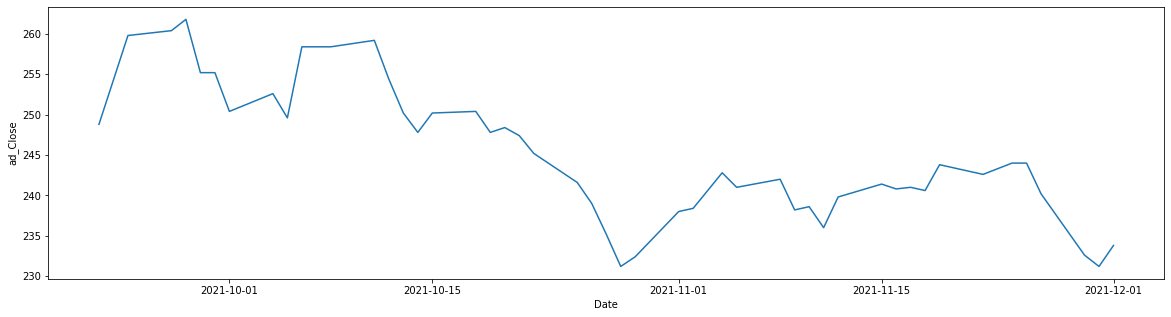

In [11]:
plt.figure(figsize=(20,5))
sns.lineplot(data=data_code, y='ad_Close', x='Date')

In [12]:
df_code = df_security_code(data, code= CODE)
df_code.drop(['SecuritiesCode'], axis=1, inplace=True)
df_code = df_code.query('Date >= @date_from')
df_code=df_code.set_index(['Date'])
#assert len(df_code.columns) == 52

2022-05-10 15:24:53.840488: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<AxesSubplot:xlabel='Date', ylabel='ad_Close'>

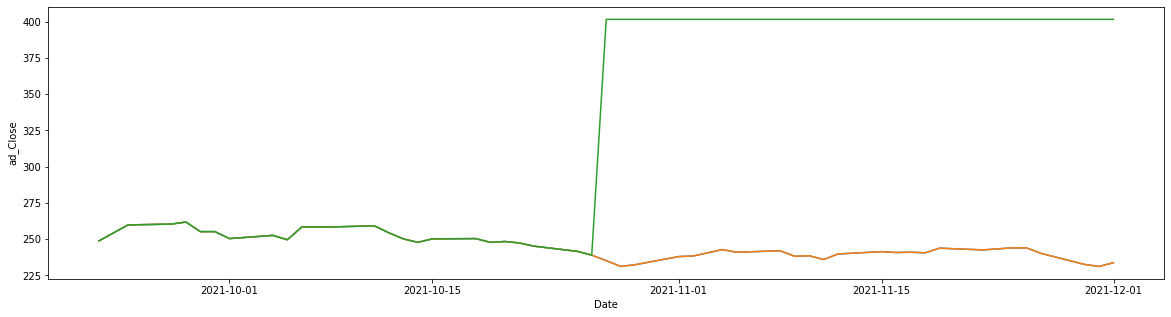

In [13]:
win_one = DFWindows(df_code, CODE)

for i in range(0, win_one.possible_windows):
    #print(i)
    #win.df_curr
    #create a window
    df_win = win_one.next_window(i)
    #df_win = win.first_window()
    #print(df_win.shape)
    win_ds = win_one.make_dataset(df_win)
    
    # predict window
    win_pred = scale_predict_unscale(win_one, win_ds, models['linear'])

    # update values for next prediction
    win_one.update_df(win_pred)

    #display(win.df_curr)
plt.figure(figsize=(20,5))
sns.lineplot(data=data_code, y='ad_Close', x='Date')
sns.lineplot(data=df_code, y='ad_Close', x='Date')
sns.lineplot(data=win_one.df_curr, y='ad_Close', x=win_one.df_curr.index)



predict with all models

MAPE_baseline: 1.41
MAPE_baseline2: 5.63
MAPE_linear: 68.22
MAPE_dense: 2.98
MAPE_conv: 5.33
MAPE_lstm: 68.22


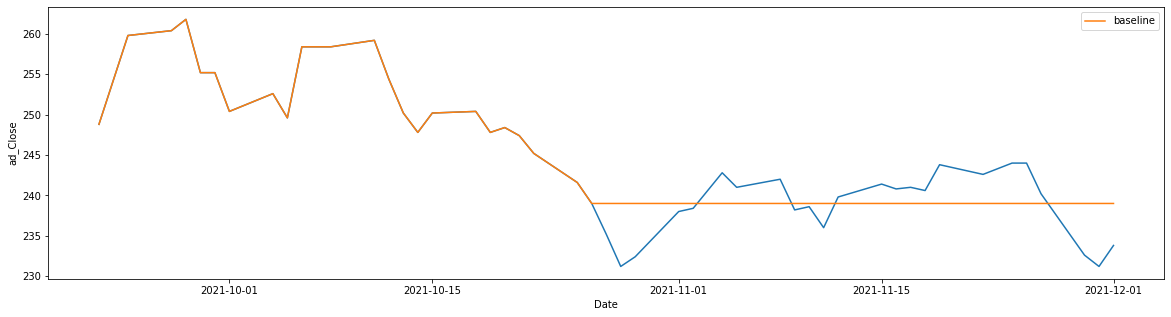

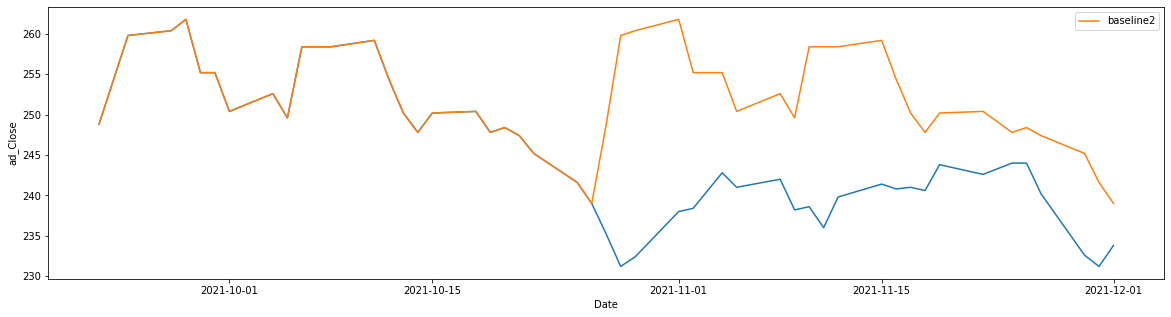

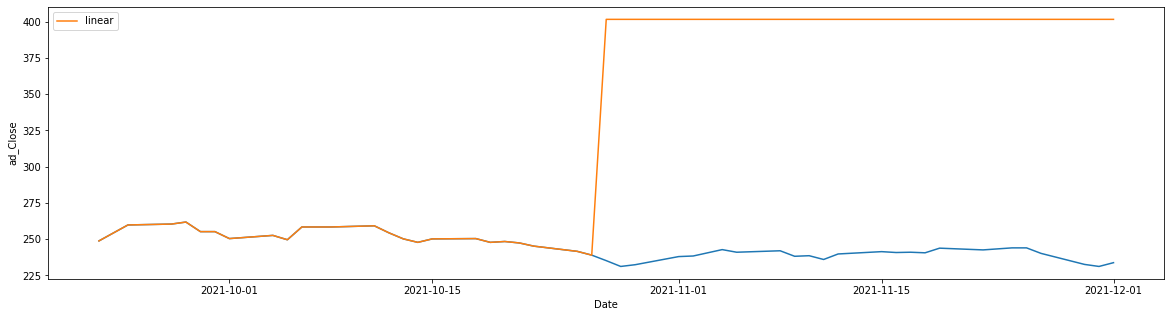

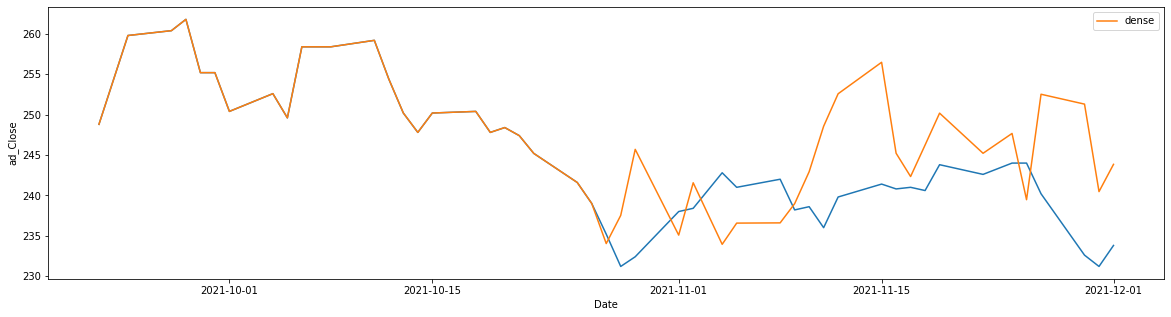

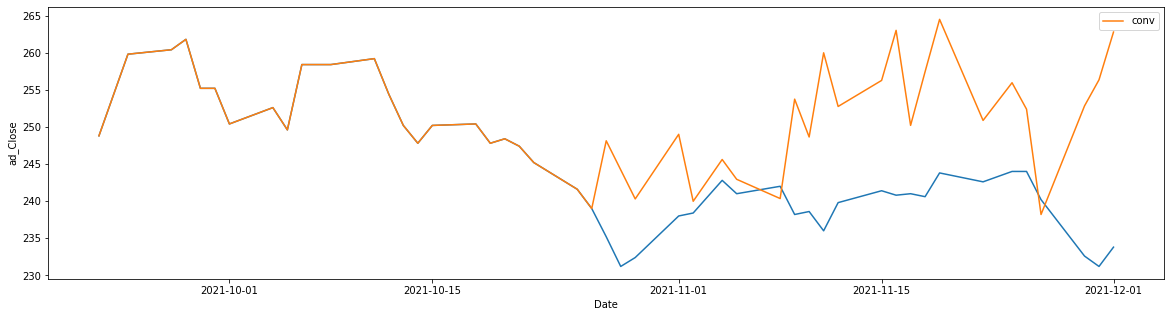

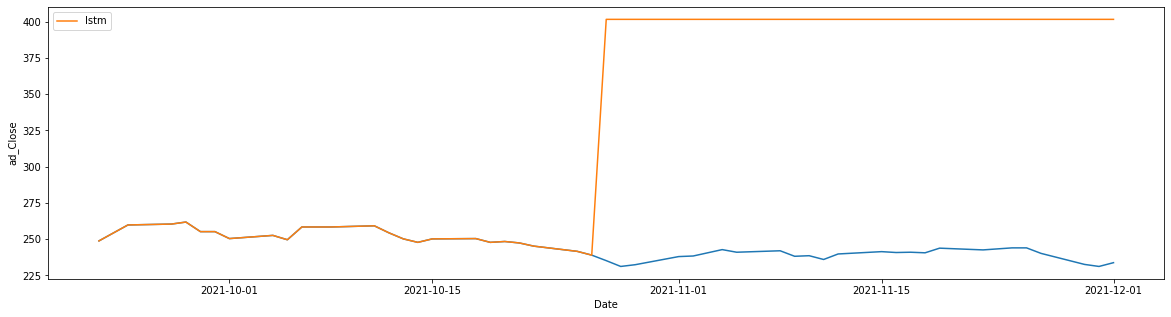

In [14]:
for mod in list(models.keys()):#, linear, lstm]: 
        
    if mod == 'feedback':continue
    
    win_one = DFWindows(df_code)
    for i in range(0, win_one.possible_windows):

        #create a window
        df_win = win_one.next_window(i)

        #make dataset
        win_ds = win_one.make_dataset(df_win)
        
        # predict window
        win_pred = scale_predict_unscale(win_one, win_ds, models[mod])
        
        # update values for next prediction
        win_one.update_df(win_pred)

    # evaluate

    new = pd.concat([df_code['ad_Close'], win_one.df_curr['ad_Close'][-PREDICTIONS:]], axis=1, join='inner', keys=['origin', 'predict'])

    mae = mean_absolute_percentage_error(new['origin'], new['predict'])*100
    print(f'MAPE_{mod}: {mae:.2f}')
        
    plt.figure(figsize=(20,5))
    sns.lineplot(data=df_code, y='ad_Close', x=df_code.index)
    sns.lineplot(data=win_one.df_curr, y='ad_Close', x=win_one.df_curr.index,label=mod)


In [15]:
del data

- for several codes 

In [16]:
assert PREDICT == 'all'

In [20]:
data_raw = pd.read_csv('../data/curr_price_financial_fill.csv', parse_dates=['Date'],  index_col=[0])
data = data_raw.query('Date > @date_from')
del data_raw
data = data[cols]

In [21]:
codes =  data.SecuritiesCode.unique()

results = {}

predicts_df = pd.DataFrame()

#codes = data.SecuritiesCode.unique()
for sec in tqdm(codes):
    df_code = df_security_code(data, sec)
    df_code.drop(['SecuritiesCode'], axis=1, inplace=True)
    df_code = df_code.query('Date >= @date_from ')
    df_code=df_code.set_index(['Date'])
    #assert len(df_code.columns) == 52
    win_all = DFWindows(df_code)
    if win_all.possible_windows < 1: continue
    for name in list(models.keys()): 
        #if name == 'lstm': continue
        if name == 'feedback': continue
        
        
        for i in range(0, win_all.possible_windows):
            
            #create a window dataset
            df_win = win_all.next_window(i)
            win_ds = win_all.make_dataset(df_win)
            
            # predict window
            win_pred = scale_predict_unscale(win_all, win_ds, models[name])

            # update values for next prediction
            win_all.update_df(win_pred)
 
        # evaluate
        
        new = pd.concat([df_code['ad_Close'], win_all.df_curr['ad_Close'][-OUT_STEPS:]], axis=1, join='inner', keys=['origin', 'predict'])

        mae = mean_absolute_percentage_error(new['origin'], new['predict'])*100

        result_name =  '{}_{}'.format(str(sec), str(name))
        results[result_name] = round(mae,2)
        #print(f'{result_name}: {mae:.2f}')

        win_all.df_curr['SecuritiesCode'] = sec
        win_all.df_curr['Model'] = name
        predicts_df= pd.concat([predicts_df, win_all.df_curr], axis=0)


100%|██████████| 2000/2000 [10:05<00:00,  3.30it/s]


In [ ]:
pd.DataFrame(results, index=[0]).T

In [ ]:
predicts_df.to_csv('allpreds_24.csv')

In [ ]:
pred = predicts_df[['Model', 'SecuritiesCode','ad_Close']]

In [ ]:
real = data[['Date', 'SecuritiesCode','ad_Close']]
real['Model'] = str('real')

In [ ]:
pred.reset_index('Date', inplace=True)

In [ ]:

date_pred = pred.Date

print(f'Predictions: ')
print('------'*10)
print(f'from: {date_pred.min().strftime("%d-%m-%Y") }')
print(f'to  : {date_pred.max().strftime("%d-%m-%Y") }')

print(f'      {date_pred.nunique()} days')

In [ ]:

real_pred = real.Date

print(f'Predictions: ')
print('------'*10)
print(f'from: {real_pred.min().strftime("%d-%m-%Y") }')
print(f'to  : {real_pred.max().strftime("%d-%m-%Y") }')

print(f'      {real_pred.nunique()} days')

In [ ]:
def error_analysis(y_test, y_pred_test, mod):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle(mod)
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    #ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    #ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    #ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    #ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

In [ ]:
predN = pred.query('Date >= datetime.date(2021, 11,1)').sort_values('Date').sort_values('SecuritiesCode') 
realN =  real.query('Date >= datetime.date(2021, 11,1)').sort_values('Date').sort_values('SecuritiesCode')

In [ ]:
# df = predN.query('Model ==@mod').sort_values('Date').sort_values('SecuritiesCode')
# df_array=np.array(df.ad_Close)

In [ ]:
# df = predN.query('Model =="linear"').sort_values('Date').sort_values('SecuritiesCode')

In [ ]:
# rea = np.array(realN.ad_Close)
# pre = np.array(df.ad_Close)
# residual = np.subtract(rea, pre)

In [ ]:
rea = np.array(realN.ad_Close)
for mod in predN.Model.unique():
    df = predN.query('Model ==@mod').sort_values('Date').sort_values('SecuritiesCode')
    pre = np.array(df.ad_Close)
    error_analysis(rea, pre, mod)



-> next evaluate